In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import json
import os

### Load example document

Image shape: (3504, 2479, 3)


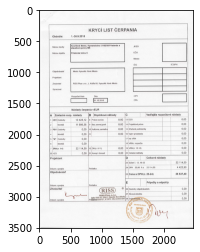

In [10]:
document_file_name = "../data/documents/stamps/faktúra.pdf-2.jpg"

image: np.ndarray = cv2.imread(document_file_name)

print(f"Image shape: {image.shape}")
plt.imshow(image)

### Downscale image
1024 should be max

use nearest interpolation

Image shape: (1024, 724, 3)


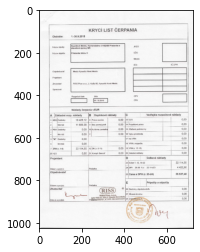

In [15]:
MAX_PIXEL_SIZE = 1024
larger_axis_size = max(image.shape[0], image.shape[1])
if larger_axis_size > MAX_PIXEL_SIZE:
    scale_factor = MAX_PIXEL_SIZE / larger_axis_size
    image = cv2.resize(image, dsize=None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)

print(f"Image shape: {image.shape}")
plt.imshow(image)

### Separate background from foreground

use Otsu's adaptive thresholding (more information here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html)

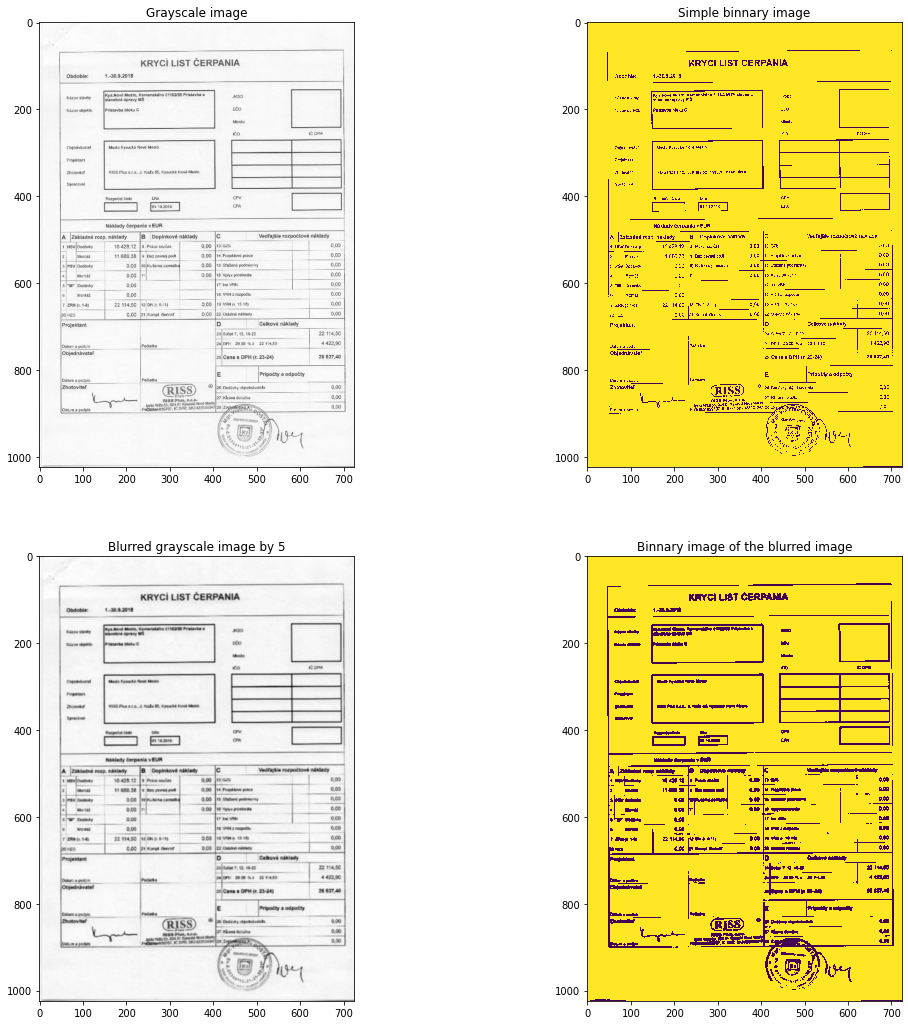

In [41]:
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Otsu's thresholding
threshold_1, binnary_image_1 = cv2.threshold(grayscale_image, 
                                         0, 255, 
                                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
BLUR_AMOUNT = 5
blurred_image = cv2.GaussianBlur(grayscale_image, (BLUR_AMOUNT, BLUR_AMOUNT), 0)
threshold_2, binnary_image_2 = cv2.threshold(blurred_image,
                                             0, 255,
                                             cv2.THRESH_BINARY + cv2.THRESH_OTSU)

def visualize_bf_fg_separation(gs_img, bin_img, blur_img, blur_bin_img):
    FIG_SIZE_INCHES = 18
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(FIG_SIZE_INCHES, FIG_SIZE_INCHES)
    axs[0, 0].imshow(gs_img, 'gray')
    axs[0, 0].set_title("Grayscale image")
    axs[0, 1].imshow(bin_img, interpolation="none")
    axs[0, 1].set_title("Simple binnary image")
    axs[1, 0].imshow(blur_img, 'gray')
    axs[1, 0].set_title(f"Blurred grayscale image by {BLUR_AMOUNT}")
    axs[1, 1].imshow(blur_bin_img, interpolation="none")
    axs[1, 1].set_title(f"Binnary image of the blurred image")
    plt.show()

visualize_bf_fg_separation(grayscale_image, binnary_image_1,
                           blurred_image, binnary_image_2)

# select the first simple approach for next steps
binnary_image = binnary_image_1
